In [ ]:
import kagglehub
kmader_skin_cancer_mnist_ham10000_path = kagglehub.dataset_download('kmader/skin-cancer-mnist-ham10000')
print('Data source import complete.')


Data source import complete.


In [ ]:

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from itertools import product
import plotly.express as px
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


In [ ]:

# --- Загрузка данных ---
base_skin_dir = kmader_skin_cancer_mnist_ham10000_path
data_directory = os.path.join(base_skin_dir)


In [ ]:

# --- Подготовка данных ---
data = pd.read_csv(os.path.join(data_directory, 'HAM10000_metadata.csv'))

imageid_path_dict = {
    os.path.splitext(os.path.basename(x))[0]: x
    for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))
}

lesion_type_dict = {
    'nv': 'Меланоформный невус МКБ-10 : D22',
    'mel': 'Меланома кожи МКБ-10 : С43',
    'bkl': 'Доброкачественный кератоз МКБ-10 : L43.9',
    'bcc': 'Базальноклеточный рак кожи МКБ-10 : C44',
    'akiec': 'Актинический кератоз МКБ - 10 : L57.0',
    'vasc': 'Сосудистые новообразования МКБ-10 : Q27.9,Q82.5',
    'df': 'Дерматофиброма МКБ-10 : D23.9'
}


In [ ]:
data.describe(include="all")

,lesion_id,image_id,dx,dx_type,age,sex,localization
count,10015,10015,10015,10015,9958.000000,10015,10015
unique,7470,10015,7,4,NaN,3,15
top,HAM_0000835,ISIC_0032258,nv,histo,NaN,male,back
freq,6,1,6705,5340,NaN,5406,2192
mean,NaN,NaN,NaN,NaN,51.863828,NaN,NaN
std,NaN,NaN,NaN,NaN,16.968614,NaN,NaN
min,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,40.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,50.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,65.000000,NaN,NaN


In [ ]:

print(data.isna().any())

lesion_id       False
image_id        False
dx              False
dx_type         False
age              True
sex             False
localization    False
dtype: bool


In [ ]:
print(data.isnull().sum())

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64


In [ ]:

skin_data = data.copy()
skin_data['path'] = skin_data['image_id'].map(imageid_path_dict.get)
skin_data['cell_type'] = skin_data['dx'].map(lesion_type_dict)
skin_data['cell_type_idx'] = pd.Categorical(skin_data['cell_type']).codes
skin_data['age'] = skin_data['age'].fillna(skin_data['age'].median())
skin_data['diagnosis_ru'] = skin_data['dx'].map(lesion_type_dict)


In [ ]:
# 3. Считаем количество по каждой категории
tmp = skin_data['diagnosis_ru'].value_counts().reset_index()
tmp.columns = ['Заболевание', 'Количество']

# 4. Строим график
fig = px.bar(tmp, x='Заболевание', y='Количество', color='Заболевание',
             title='Распределение заболеваний кожи',
             text_auto=True)

fig.update_layout(
    xaxis_title="Заболевание",
    yaxis_title="Количество изображений",
    legend_title="Заболевания"
)

fig.show()



In [ ]:


tmp = skin_data['sex'].value_counts()
tmp = tmp.reset_index()
tmp.columns = ['sex', 'count']

fig = px.pie(tmp, values='count', names='sex', title='Соотношение мужчин и женщин')
fig.show()


NameError: name 'skin_data' is not defined

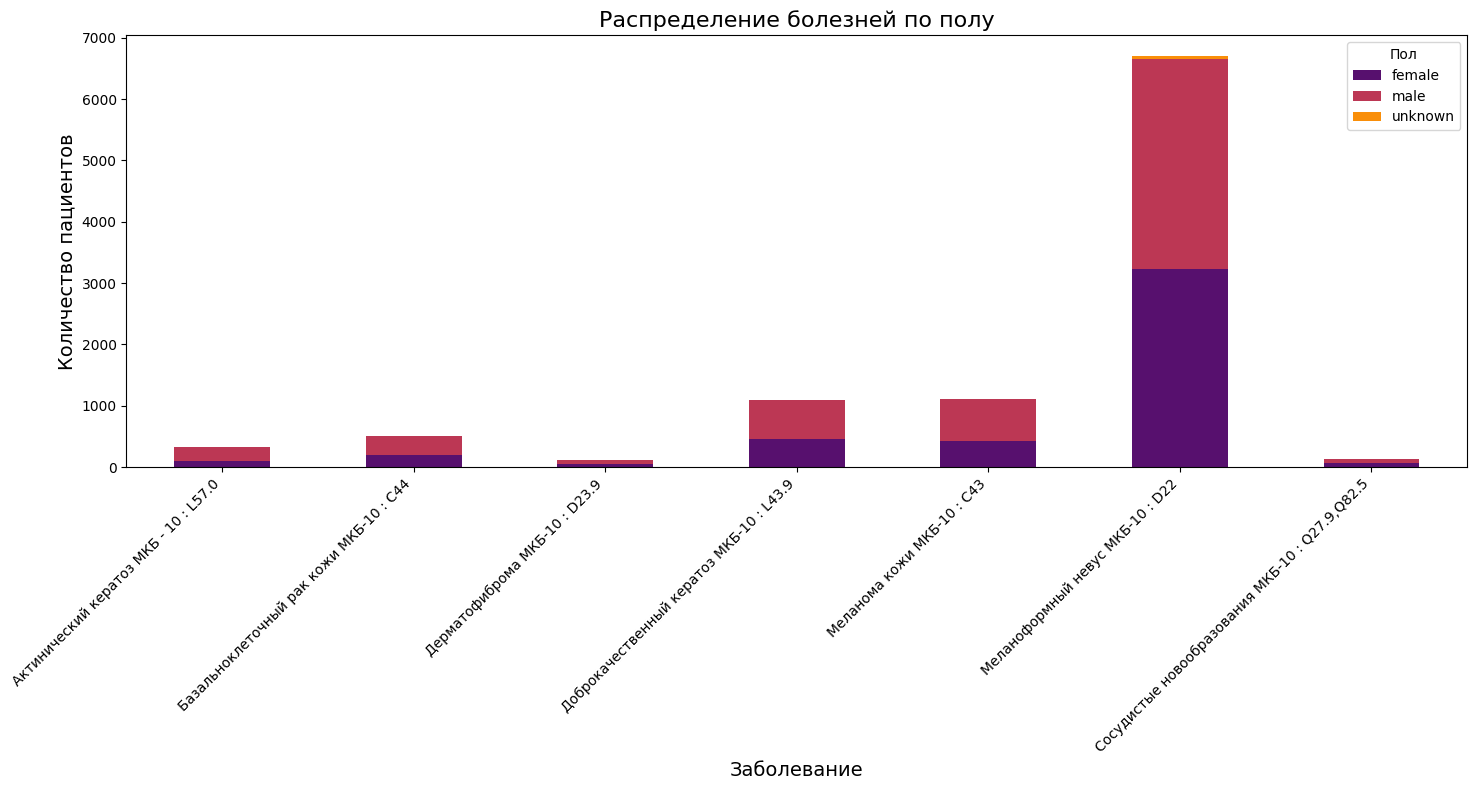

In [ ]:
# Создаем столбец с русскими названиями
data['dx_ru'] = data['dx'].map(lesion_type_dict)
grouped = data.groupby(['dx_ru', 'sex']).size().unstack()

ax = grouped.plot(kind='bar', stacked=True, figsize=(15, 8), color=sns.color_palette("inferno", 3))

plt.title('Распределение болезней по полу', fontsize=16)
plt.xlabel('Заболевание', fontsize=14)
plt.ylabel('Количество пациентов', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.legend(title='Пол')
plt.show()

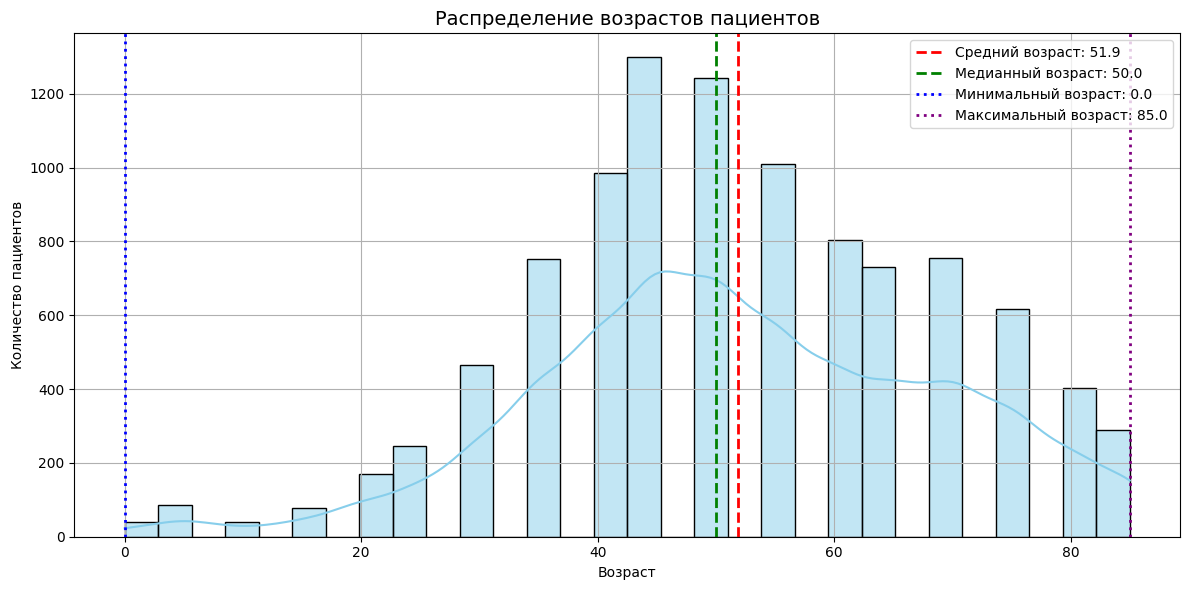

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(skin_data['age'], bins=30, kde=True, color='skyblue')

# Среднее, медиана, минимум и максимум
mean_age = skin_data['age'].mean()
median_age = skin_data['age'].median()
min_age = skin_data['age'].min()
max_age = skin_data['age'].max()

plt.axvline(mean_age, color='red', linestyle='dashed', linewidth=2,
            label=f'Средний возраст: {mean_age:.1f}')
plt.axvline(median_age, color='green', linestyle='dashed', linewidth=2,
            label=f'Медианный возраст: {median_age:.1f}')
plt.axvline(min_age, color='blue', linestyle='dotted', linewidth=2,
            label=f'Минимальный возраст: {min_age}')
plt.axvline(max_age, color='purple', linestyle='dotted', linewidth=2,
            label=f'Максимальный возраст: {max_age}')

plt.title('Распределение возрастов пациентов', fontsize=14)
plt.xlabel('Возраст')
plt.ylabel('Количество пациентов')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

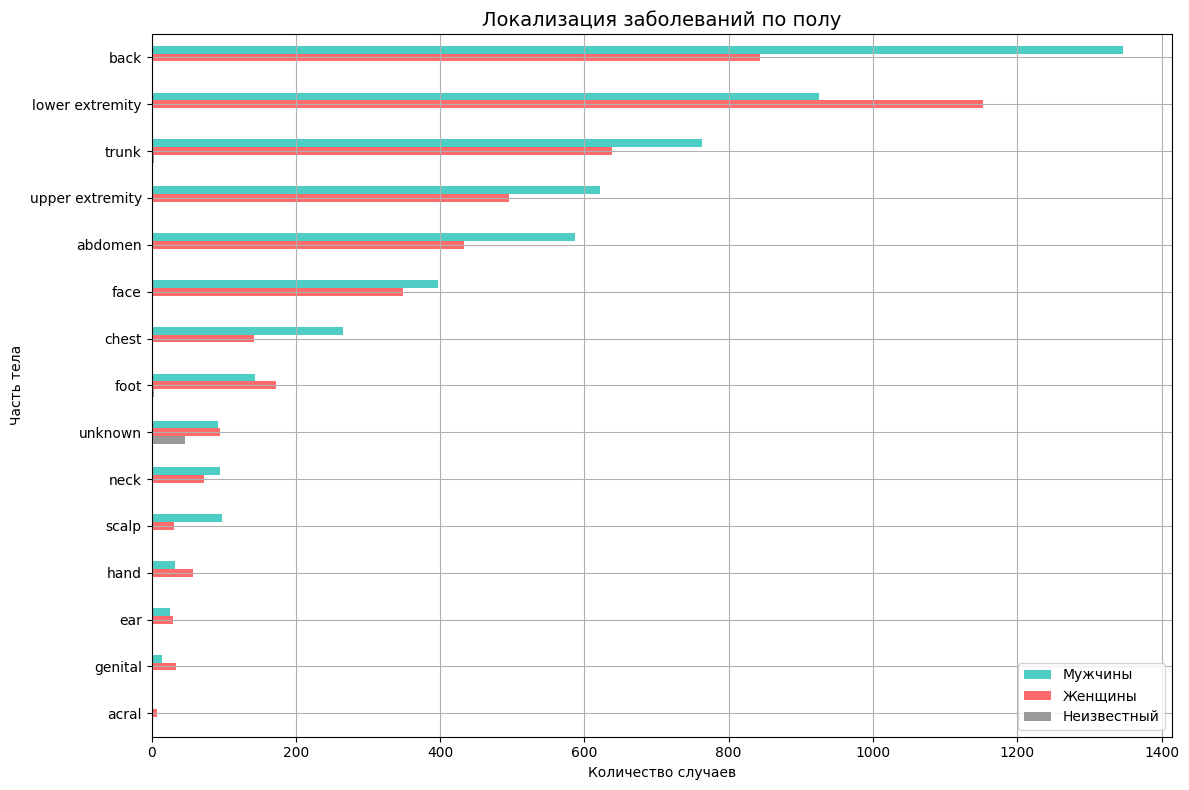

In [ ]:
# Если в 'sex' есть NaN, заполним их значением 'unknown'
skin_data['sex'] = skin_data['sex'].fillna('unknown')


 # Группируем данные
body_part_by_sex = pd.crosstab(index=skin_data['localization'], columns=skin_data['sex'], margins=True)

# Сортируем по общему количеству
body_part_by_sex = body_part_by_sex.sort_values(by='All', ascending=False).drop(index='All')

    # Визуализация
body_part_by_sex[['male', 'female', 'unknown']].plot(kind='barh', figsize=(12, 8),
                                                         color=['#4ECDC4', '#FF6B6B', '#999999'])
plt.title('Локализация заболеваний по полу', fontsize=14)
plt.xlabel('Количество случаев')
plt.ylabel('Часть тела')
plt.gca().invert_yaxis()  # Чтобы самая частая была сверху
plt.legend(['Мужчины', 'Женщины', 'Неизвестный'])
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:

# --- Загрузка изображений ---
def load_image(path):
    return np.array(Image.open(path).resize((100, 75)))

skin_data['image'] = skin_data['path'].apply(load_image)


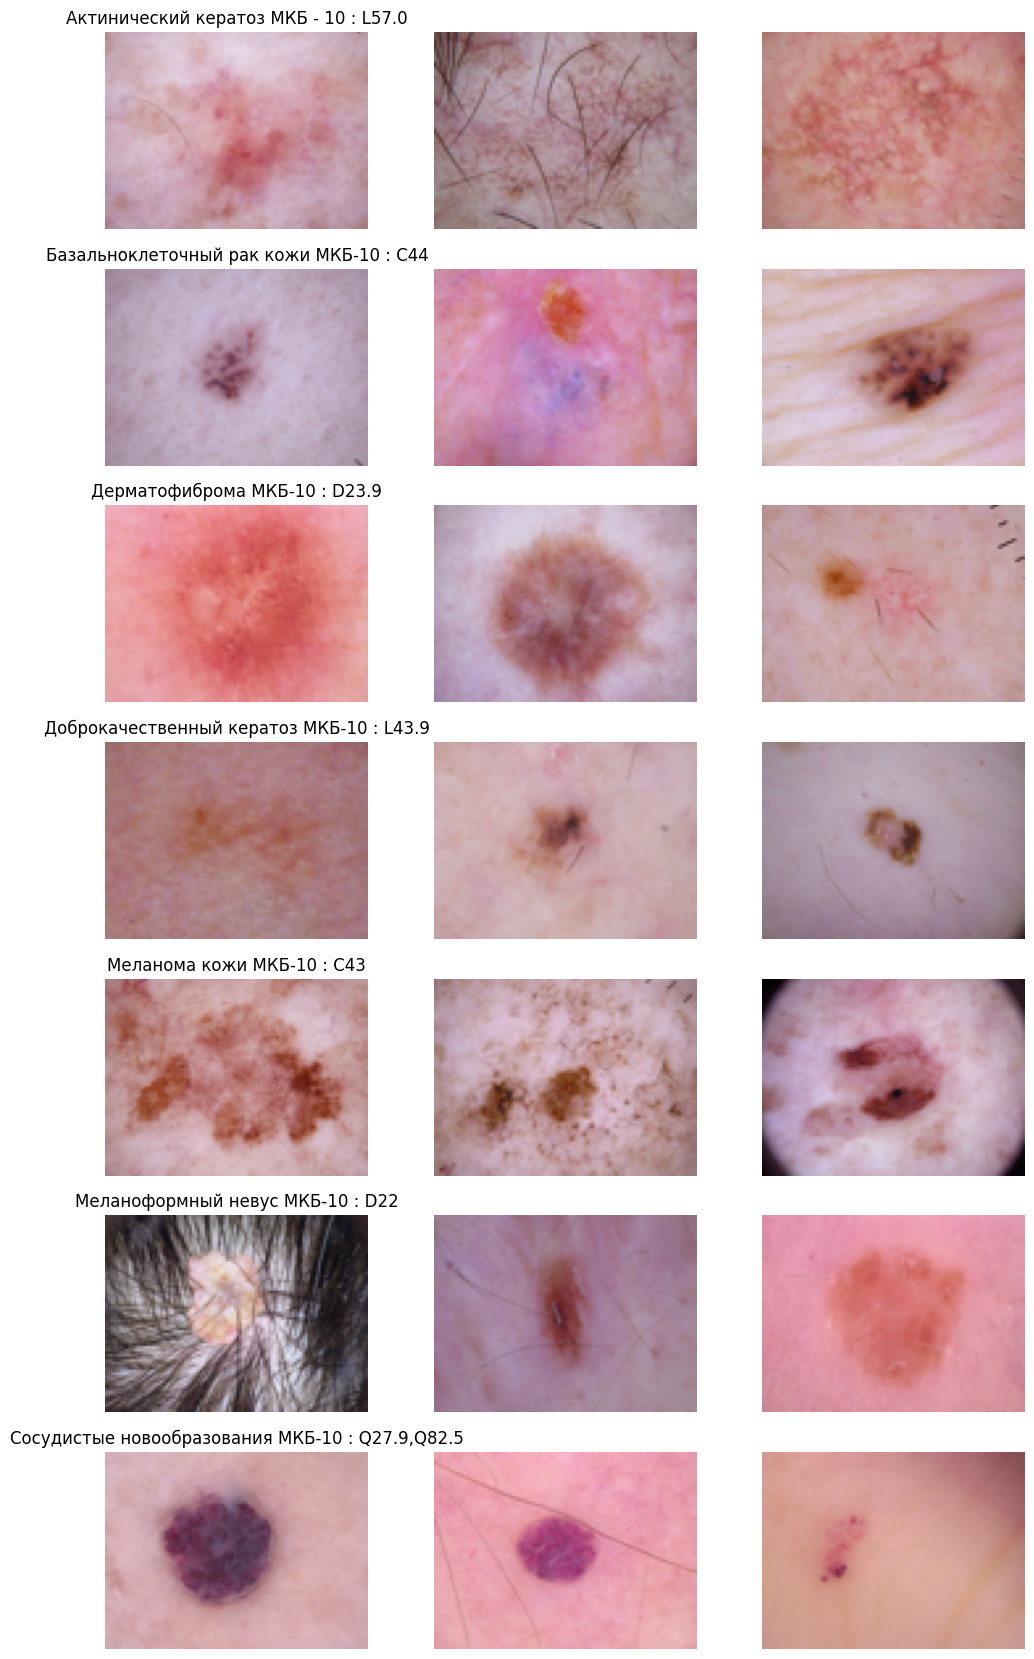

In [ ]:
n_samples=3
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs,skin_data.sort_values(['cell_type']).groupby('diagnosis_ru')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=2018).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [ ]:

# --- Нормализация и разбиение ---
X = np.stack(skin_data['image'])
y = skin_data['cell_type_idx']

X = X.astype('float32') / 255.0
y = to_categorical(y, num_classes=7)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)


In [ ]:

# --- Аугментация данных ---
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)
datagen.fit(X_train)


In [ ]:

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation

In [ ]:

# --- Улучшенная модель CNN ---
model = Sequential([
    Conv2D(32, (3,3), input_shape=(75, 100, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(64, (3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(128, (3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(256, (3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),
    Dense(256),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),

    Dense(7, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:

# --- Callbacks ---
checkpoint = ModelCheckpoint('/content/drive/MyDrive/models/best_model.keras', save_best_only=True, monitor='val_loss')
early_stop = EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=3)


In [ ]:

# --- Обучение ---
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    epochs=25,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, early_stop, reduce_lr],
                    verbose=2)


Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


226/226 - 220s - 975ms/step - accuracy: 0.6476 - loss: 1.0363 - val_accuracy: 0.1397 - val_loss: 1.7291 - learning_rate: 1.0000e-03
Epoch 2/25
226/226 - 258s - 1s/step - accuracy: 0.6913 - loss: 0.8224 - val_accuracy: 0.6521 - val_loss: 0.9083 - learning_rate: 1.0000e-03
Epoch 3/25
226/226 - 211s - 932ms/step - accuracy: 0.7031 - loss: 0.7823 - val_accuracy: 0.6434 - val_loss: 1.0582 - learning_rate: 1.0000e-03
Epoch 4/25
226/226 - 208s - 922ms/step - accuracy: 0.7198 - loss: 0.7603 - val_accuracy: 0.6858 - val_loss: 0.9959 - learning_rate: 1.0000e-03
Epoch 5/25
226/226 - 209s - 926ms/step - accuracy: 0.7219 - loss: 0.7368 - val_accuracy: 0.6908 - val_loss: 0.9073 - learning_rate: 1.0000e-03
Epoch 6/25
226/226 - 215s - 949ms/step - accuracy: 0.7350 - loss: 0.7231 - val_accuracy: 0.6484 - val_loss: 0.8718 - learning_rate: 1.0000e-03
Epoch 7/25
226/226 - 219s - 971ms/step - accuracy: 0.7345 - loss: 0.7075 - val_accuracy: 0.7182 - val_loss: 0.9723 - learning_rate: 1.0000e-03
Epoch 8/25
22

In [ ]:

# --- Оценка модели ---
score = model.evaluate(X_test, y_test, verbose=0)
print(f"Тестовая точность: {score[1]:.4f}")


Тестовая точность: 0.7738


In [2]:
model.save('model.keras')

NameError: name 'model' is not defined

In [ ]:
model.save_weights('model_weights.keras')

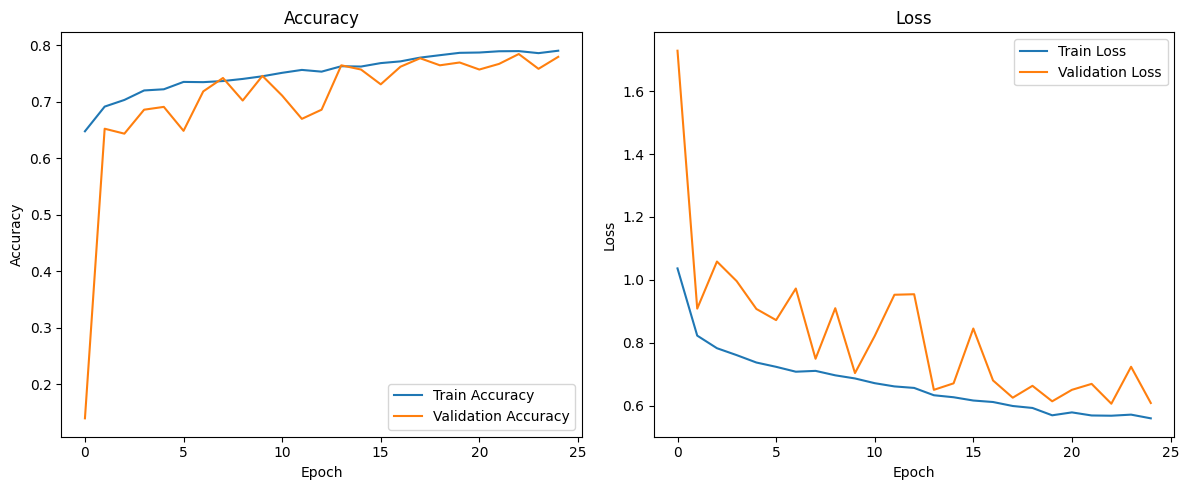

In [ ]:

# --- График обучения ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 182ms/step


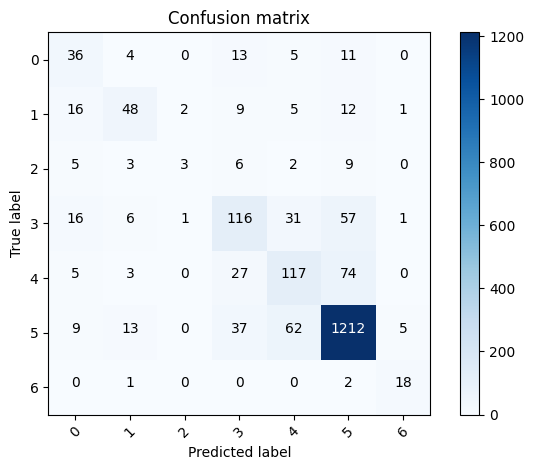

In [ ]:

# --- Confusion Matrix ---
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(y_test, axis=1)

conf_mtx = confusion_matrix(Y_true, Y_pred_classes)
def plot_confusion_matrix(cm, classes, title='Confusion matrix'):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

plot_confusion_matrix(conf_mtx, classes=range(7))
plt.show()


In [ ]:

# --- Classification Report ---
report = classification_report(Y_true, Y_pred_classes, target_names=lesion_type_dict.values())
print("Classification Report:\n", report)


Classification Report:
                                               precision    recall  f1-score   support

                       Меланоцитарные невусы       0.41      0.52      0.46        69
                                    Меланома       0.62      0.52      0.56        93
Доброкачественные кератозоподобные поражения       0.50      0.11      0.18        28
                 Базальноклеточная карцинома       0.56      0.51      0.53       228
                       Актинические кератозы       0.53      0.52      0.52       226
                        Сосудистые поражения       0.88      0.91      0.89      1338
                              Дерматофиброма       0.72      0.86      0.78        21

                                    accuracy                           0.77      2003
                                   macro avg       0.60      0.56      0.56      2003
                                weighted avg       0.77      0.77      0.77      2003



63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 169ms/step


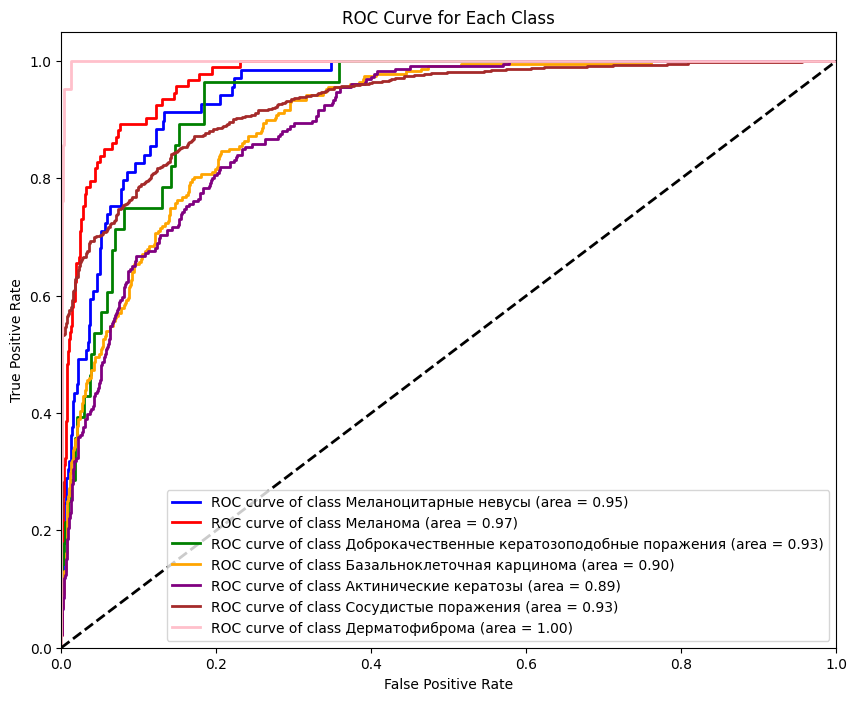

In [ ]:

# --- ROC Curve ---
y_score = model.predict(X_test)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink']
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(list(lesion_type_dict.values())[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc="lower right")
plt.show()